In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
import time

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.variational.double_stochastic import DoubleStochasticVI
from mcjax.proba.gaussian import Gauss
from mcjax.proba.banana2d import Banana2D

# import variational distributions
from mcjax.proba.var_gaussian import DiagGaussian, FullCovGaussian, \
    MixtureDiagGaussian

from mcjax.util.plot_2d import evaluate_on_grid_2d



In [2]:
# initialize PRNG
key = jr.key(0)

In [3]:
# mu_star = jnp.array([1., 1.])
# cov_star = jnp.array([[1., 0.97], [0.97, 1.]])
# dist = Gauss(mu=mu_star, cov=0.1*cov_star)
dist = Banana2D(noise_std=0.2)
logdensity = dist.logdensity
logdensity_batch = jax.vmap(logdensity)

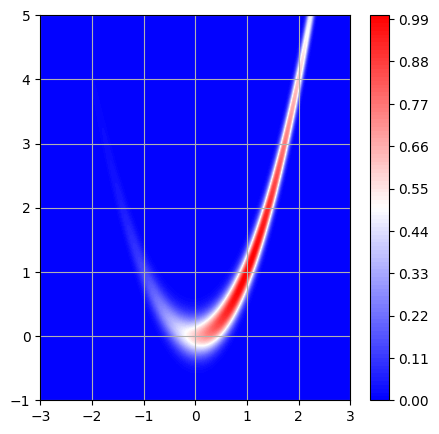

In [4]:
xmin, xmax = -3, 3
ymin, ymax = -1, 5
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.grid()


In [12]:

# setup the variational family
dim = 2
approx_diag = DiagGaussian(dim=dim)
aprox_full = FullCovGaussian(dim=dim)
num_components = 10
approx_mixture = MixtureDiagGaussian(dim=dim, num_components=num_components)

In [13]:
# Set up VI driver
vi_diag = DoubleStochasticVI(
    logdensity=logdensity,
    approx=approx_diag,
    sticking_the_landing=True,)

vi_full = DoubleStochasticVI(
    logdensity=logdensity,
    approx=aprox_full,
    sticking_the_landing=True,)

vi_mixture = DoubleStochasticVI(
    logdensity=logdensity,
    approx=approx_mixture,
    sticking_the_landing=True,)

vi_list = [vi_diag, vi_full, vi_mixture]
vi_names = ['diag', 'full', 'mixture']

In [14]:
key, key_ = jr.split(key)
result_dict = {}

n_iter = 10_000
n_samples = 100
lr = 1e-2
for vi_engine, name in zip(vi_list, vi_names):
    print(f'Running {name} variational inference with: {n_iter} iterations, {n_samples} samples, and lr={lr}')
    # run the variational inference
    time_start = time.time()
    result = vi_engine.run(
        key=key_,
        n_iter=n_iter,
        n_samples=n_samples,
        lr=lr,
        use_jit=True,
        store_params_trace=False,
        verbose=False,)
    time_end = time.time()
    print(f'\t Elapsed time: {time_end - time_start:.2f} seconds')
    result_dict[name] = result


Running diag variational inference with: 10000 iterations, 100 samples, and lr=0.01
	 Elapsed time: 1.74 seconds
Running full variational inference with: 10000 iterations, 100 samples, and lr=0.01
	 Elapsed time: 1.97 seconds
Running mixture variational inference with: 10000 iterations, 100 samples, and lr=0.01
	 Elapsed time: 5.24 seconds


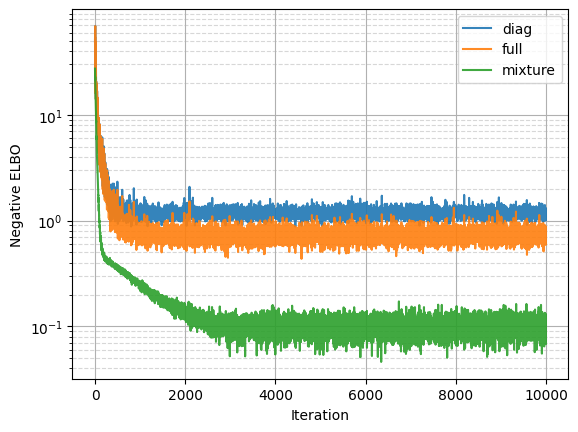

In [15]:
for name, result in result_dict.items():
    kl_trace = np.array(result['kl_trace'])
    plt.plot(kl_trace, label=name, alpha=0.9)
plt.xlabel('Iteration')
plt.ylabel('Negative ELBO')
plt.legend()
plt.yscale('log')
plt.grid(which="major", linestyle='-')
plt.grid(which="minor", linestyle='--', alpha=0.5)

In [19]:
result_dict["diag"]["params"]

{'mu': Array([0.09543833, 0.09650721], dtype=float32),
 'std': Array([0.2916461, 0.1991955], dtype=float32)}

In [20]:
mu_diag = result_dict["diag"]["params"]["mu"]
std_diag = result_dict["diag"]["params"]["std"]
cov_diag = jnp.diag(std_diag**2)

In [ ]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')


outputs = [run_output_diag, run_output_full]
output_type = ["mean field", "full"]
output_color = ["green", "yellow"]
for index, run_output in enumerate(outputs):
    # plot the final approximation
    it = -1
    if run_output["approx_type"] == "diag":
        mu = run_output["params_trace"][it]["mu"]
        log_stds = run_output["params_trace"][it]["log_std"]
        cov = jnp.diag(jnp.exp(2*log_stds))
    elif run_output["approx_type"] == "full":
        mu = run_output["params_trace"][it]["mu"]
        J = run_output["params_trace"][it]["cov_chol"]
        cov = J @ J.T


    #plt.subplot(1, 2, index+1)
    # draw the ellipse associated to the Gaussian N(mu, cov)
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    angle = 180 * angle / jnp.pi
    # fill the ellipse with color yellow
    ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                  angle=angle, color=output_color[index],
                  alpha=0.5, label=output_type[index])
    ax.add_artist(ell)
    # draw another ellipse, but with only the edge in black
    ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                    angle=angle, edgecolor='black', fill=False, 
                    linewidth=1)
    # add a star at the center of the ellipse
    # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
    ax.add_artist(ell_edge)
    
plt.legend(loc='lower right')

In [23]:
result_dict["full"]["params"]

{'mu': Array([0.9879364, 1.0593696], dtype=float32),
 'cov_chol': Array([[0.303527  , 0.        ],
        [0.6007411 , 0.19916686]], dtype=float32),
 'cov': Array([[0.09212864, 0.18234114],
        [0.18234114, 0.40055728]], dtype=float32)}

In [ ]:
def create_ellipse(mu, cov, color='green', alpha=0.5, label=None, edgecolor='black'):
    # Compute ellipse geometry
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0]) * 180 / jnp.pi
    width, height = 2 * jnp.sqrt(eigvals)

    # Add filled ellipse (approximate posterior)
    ell = Ellipse(
        xy=mu,
        width=width,
        height=height,
        angle=angle,
        color=color,
        alpha=alpha,
        label=label,
        edgecolor=edgecolor,
        )
    return ell

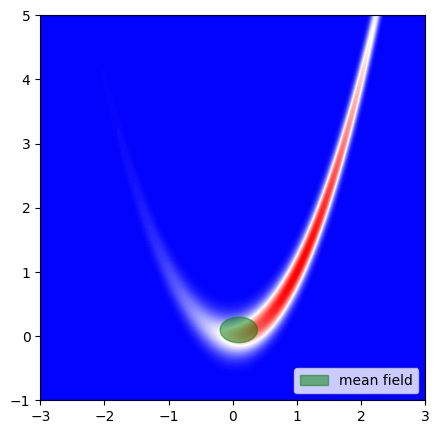

In [30]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

# Extract final mean-field (diag) parameters
mu_diag = result_dict["diag"]["params"]["mu"]
std_diag = result_dict["diag"]["params"]["std"]
cov_diag = jnp.diag(std_diag ** 2)

# Extract final full covariance parameters
mu_full = result_dict["full"]["params"]["mu"]
cov_full = result_dict["full"]["params"]["cov"]

mu = mu_diag
cov = cov_diag


# Plot background density
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')

ell = create_ellipse(mu, cov, color='green', alpha=0.5)
ax.add_artist(ell)

# Optional: add a star at the mean
# ax.plot(mu[0], mu[1], marker="*", color="black", markersize=10)

# Finalize
ax.set_aspect("equal")
plt.legend(loc="lower right")

In [ ]:
key, key_ = jr.split(key)
n_samples = 100
n_iter  = 10_000
verbose = False
store_params_trace = True
adam_lr = 0.01
use_jit = True

# run mean_field
approx_type = 'diag'
mu_init = jnp.array([0., 2.])
cov_init = jnp.eye(2)
run_output_diag = approx.run(key=key_, n_samples=n_samples,
                        mu_init=mu_init, cov_init=cov_init,
                        n_iter=n_iter, verbose=verbose, store_params_trace=store_params_trace,
                        adam_lr=adam_lr, use_jit=use_jit,
                        approx_type=approx_type)

# # run full gaussian
approx_type = 'full'
mu_init = jnp.array([0., 2.])
cov_init = jnp.eye(2)
run_output_full = approx.run(key=key_, n_samples=n_samples,
                             mu_init=mu_init, cov_init=cov_init,
                             n_iter=n_iter, verbose=verbose, store_params_trace=store_params_trace,
                             adam_lr=adam_lr, use_jit=use_jit,
                             approx_type=approx_type)

In [ ]:
# run mixture
key, key_ = jr.split(key)
n_samples = 100
n_iter  = 10_000
verbose = False
store_params_trace = True
adam_lr = 0.01
use_jit = True

approx_type = 'mixture'
mu_init = jnp.array([0., 2.])
cov_init = jnp.eye(2)
#mixing_components = 30
mixing_components = 10
run_output_mixture = approx.run(key=key_, n_samples=n_samples,
                             mu_init=mu_init, cov_init=cov_init,
                             n_iter=n_iter, verbose=verbose, store_params_trace=store_params_trace,
                             adam_lr=adam_lr, use_jit=use_jit,
                             approx_type=approx_type,
                             mixing_components=mixing_components)

In [ ]:
plt.plot( np.array(run_output_diag["kl_trace"]), label="mean_field")
plt.plot( np.array(run_output_full["kl_trace"]), label="full")
plt.plot( np.array(run_output_mixture["kl_trace"]), label="mixture")
plt.yscale('log')
plt.grid(which="major", linestyle="--", color="black", alpha=1)
plt.grid(which="minor", linestyle=":", color="black", alpha=0.5)
plt.legend()

In [ ]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')


outputs = [run_output_diag, run_output_full]
output_type = ["mean field", "full"]
output_color = ["green", "yellow"]
for index, run_output in enumerate(outputs):
    # plot the final approximation
    it = -1
    if run_output["approx_type"] == "diag":
        mu = run_output["params_trace"][it]["mu"]
        log_stds = run_output["params_trace"][it]["log_std"]
        cov = jnp.diag(jnp.exp(2*log_stds))
    elif run_output["approx_type"] == "full":
        mu = run_output["params_trace"][it]["mu"]
        J = run_output["params_trace"][it]["cov_chol"]
        cov = J @ J.T


    #plt.subplot(1, 2, index+1)
    # draw the ellipse associated to the Gaussian N(mu, cov)
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    angle = 180 * angle / jnp.pi
    # fill the ellipse with color yellow
    ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                  angle=angle, color=output_color[index],
                  alpha=0.5, label=output_type[index])
    ax.add_artist(ell)
    # draw another ellipse, but with only the edge in black
    ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                    angle=angle, edgecolor='black', fill=False, 
                    linewidth=1)
    # add a star at the center of the ellipse
    # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
    ax.add_artist(ell_edge)
    
plt.legend(loc='lower right')

In [ ]:
# create animation with celluloid
from celluloid import Camera
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5, 5))

# create camera
camera = Camera(fig)

# create a list of iterations to plot
nframes = 100
it_list = np.linspace(0, 500, nframes).astype(int)

first_time = True
for it in it_list:
    ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
    outputs = [run_output_diag, run_output_full]
    output_type = ["mean field", "full"]
    output_color = ["green", "yellow"]
    for index, run_output in enumerate(outputs):
        # plot the final approximation
        if run_output["approx_type"] == "diag":
            mu = run_output["params_trace"][it]["mu"]
            log_stds = run_output["params_trace"][it]["log_std"]
            cov = jnp.diag(jnp.exp(2*log_stds))
        elif run_output["approx_type"] == "full":
            mu = run_output["params_trace"][it]["mu"]
            J = run_output["params_trace"][it]["cov_chol"]
            cov = J @ J.T


        #plt.subplot(1, 2, index+1)
        # draw the ellipse associated to the Gaussian N(mu, cov)
        eigvals, eigvecs = jnp.linalg.eigh(cov)
        angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        angle = 180 * angle / jnp.pi
        # fill the ellipse with color yellow
        ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                    angle=angle, color=output_color[index],
                    alpha=0.5, label=output_type[index])
        ax.add_artist(ell)
        # draw another ellipse, but with only the edge in black
        ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                        angle=angle, edgecolor='black', fill=False, 
                        linewidth=1)
        # add a star at the center of the ellipse
        # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
        ax.add_artist(ell_edge)
        
    # do not display axis
    ax.axis('off')
        
    # add legend
    if first_time:
        first_time = False
        ax.legend(loc='lower right')
        # add title
        ax.set_title("Gaussian Variational approximation", fontsize=15)
    
    # snap the current plot
    camera.snap()
    
# create animation
animation = camera.animate()

In [ ]:
# display animation
HTML(animation.to_html5_video())

In [ ]:
# save the video in mp4
animation.save('gaussian_variational_approximation.mp4', fps=10, dpi=300)

### Plot Mixtures

In [ ]:
outputs

In [ ]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')


run_output = run_output_mixture
#K = len(outputs["params"]["mus"])
K = len(run_output["params_trace"][0]["mus"])

# plot the final approximation
it = 5000
for k in range(K):
    mu = run_output["params_trace"][it]["mus"][k]
    log_stds = run_output["params_trace"][it]["log_stds"][k]
    cov = jnp.diag(jnp.exp(2*log_stds))
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    angle = 180 * angle / jnp.pi
    # fill the ellipse with color yellow
    ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                    angle=angle, color=output_color[index],
                    alpha=0.5, label=output_type[index])
    ax.add_artist(ell)
    # draw another ellipse, but with only the edge in black
    ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                    angle=angle, edgecolor='black', fill=False, 
                    linewidth=1)
    # add a star at the center of the ellipse
    # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
    ax.add_artist(ell_edge)


In [ ]:
# create animation with celluloid
from celluloid import Camera
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5, 5))

# create camera
camera = Camera(fig)

# create a list of iterations to plot
nframes = 100
final_frame = 10_000
alpha = 0.7
it_list_1 =  (10**np.linspace(0, np.log10(final_frame*alpha), int(nframes*alpha))).astype(int)
it_list_2 =  np.linspace(final_frame*alpha, final_frame, nframes-int(nframes*alpha)).astype(int)
it_list = np.concatenate([it_list_1, it_list_2])
#it_list = np.linspace(0, 10_000, nframes).astype(int)

first_time = True
run_output = run_output_mixture
K = len(outputs["params"]["mus"])
for it in it_list:
    ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
    # plot the gaussian mixture
    for k in range(K):
        mu = run_output["params_trace"][it]["mus"][k]
        log_stds = run_output["params_trace"][it]["log_stds"][k]
        cov = jnp.diag(jnp.exp(2*log_stds))
        eigvals, eigvecs = jnp.linalg.eigh(cov)
        angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        angle = 180 * angle / jnp.pi
        # fill the ellipse with color yellow
        ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                        angle=angle, color=output_color[index],
                        alpha=0.7, label=output_type[index])
        ax.add_artist(ell)
        # draw another ellipse, but with only the edge in black
        ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                        angle=angle, edgecolor='black', fill=False, 
                        linewidth=1)
        # add a star at the center of the ellipse
        # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
        ax.add_artist(ell_edge)
        
    # do not display axis
    ax.axis('off')
        
    # add legend
    if first_time:
        first_time = False
        # add title
        ax.set_title("Gaussian Mixture Variational Approx.", fontsize=14)
    
    # snap the current plot
    camera.snap()
    
# create animation
animation = camera.animate()

In [ ]:
# display animation
HTML(animation.to_html5_video())

In [ ]:
animation.save('mixture_gaussian_variational_approx.mp4', fps=10, dpi=300)